In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline 

import skimage.io
import skimage.transform

from scipy.misc import imresize
from sklearn.preprocessing import label_binarize

from keras.models import model_from_json
from keras.models import load_model
from keras import optimizers
from keras.preprocessing.image import img_to_array
from keras.callbacks import ModelCheckpoint

from pathlib import Path

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def loadPretrainedModel(name):
    model = load_model(name)
    print("Loaded pretrained model with weights from disk")
    return model

In [3]:
###############################################################################################################################
###Remember to change the all variables (especially weightsFile name) before executing the code.
###############################################################################################################################
#Directory names of the folders that contain the images that need to be trained and tested for.
trainDir = 'Flickr27//CTrain-GreyScale'
testDir = 'Flickr27//CValidation-GreyScale'

#The list of class names for which label binarizer is run
class_names = ['Apple', 'Fedex', 'Google']

#channels = 3 ==> RGB or HSV images, channels = 1 ==> Greyscale images
channels = 1

#Normalization value should be 255 for RGB or Greyscale images. It should be 1 for HSV images.
normalizationVal = 255.0

#Pretrained Model Filename
modelFileName = 'Models//NewIV3-150x150x1-3C.h5'
withPreTrainedWeights = False #Greyscale model has no pretrained weights. Keep this as false.

#The filename in which the output weights would be stored.
outputWeightsFileName = 'NewIV3-150x150x1-3C-Run1.hdf5'

#Other parameters
epochs = 100
batchsize = 32
learningRate = 0.001
monitorVariable = 'val_categorical_accuracy'
monitorMode = 'max'

In [4]:
#Converting the images to numpy arrays
X_train = []
y_train = []

X_test = []
y_test = []

#For the train images
for dirname in os.listdir(trainDir):
    if dirname in class_names:
        classdir = trainDir + '//' + dirname
        for filename in os.listdir(classdir):
            if filename.endswith('.jpg'):
                fnWithPath = classdir + '//' + filename
                image_data = skimage.io.imread(fnWithPath)
                new_image_data = skimage.transform.resize(image_data,(150,150,channels))
                new_image_data = new_image_data.reshape((1, 150, 150, channels)).astype(np.float32) / normalizationVal
                X_train.append(new_image_data)
                y_train.append(dirname)
        
#For the validation images
for dirname in os.listdir(testDir):
    if dirname in class_names:
        classdir = testDir + '//' + dirname
        for filename in os.listdir(classdir):
            if filename.endswith('.jpg'):
                fnWithPath = classdir + '//' + filename
                image_data = skimage.io.imread(fnWithPath)
                new_image_data = skimage.transform.resize(image_data,(150,150,channels))
                new_image_data = new_image_data.reshape((1, 150, 150, channels)).astype(np.float32) / normalizationVal
                X_test.append(new_image_data)
                y_test.append(dirname)

C:\Users\Prem Thomas Eapen\AppData\Roaming\Python\Python36\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [5]:
print(np.size(X_train))
print(np.size(y_train)) #The total number of train images per class
print(np.size(X_test))
print(np.size(y_test))  #The total number of test images per class

129600000
5760
32400000
1440


In [6]:
X_train = np.reshape(X_train,(np.size(y_train),150,150,channels))
y_train = np.reshape(y_train,(np.size(y_train),1))
X_test = np.reshape(X_test,(np.size(y_test),150,150,channels))
y_test = np.reshape(y_test,(np.size(y_test),1))

In [7]:
y_train = label_binarize(y_train, classes = class_names)
y_test = label_binarize(y_test, classes = class_names)

In [8]:
model = loadPretrainedModel(modelFileName)

Loaded pretrained model with weights from disk


C:\ProgramData\Anaconda3\lib\site-packages\keras\models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [9]:
#Will run if there are pretrained weights by setting the layers as not trainable. This will be transfer learning. 
if withPreTrainedWeights:
    for layer in model.layers[:-1]:
        layer.trainable = False

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [11]:
#Checking if this is an addition run to the original run.
#weightsFile = Path(outputWeightsFileName)
#if weightsFile.is_file():
#     model.load_weights(outputWeightsFileName)
#     print('Weight file exists. Adding new runs.')
# else:
#     print('Determining the weights for the first time.')

In [12]:
opt = optimizers.RMSprop(lr=learningRate)

model.compile(optimizer = opt, 
              loss      = 'categorical_crossentropy', 
              metrics   = ['categorical_accuracy'])

In [13]:
checkpointer = ModelCheckpoint(filepath       = outputWeightsFileName, 
                               monitor        = monitorVariable, 
                               verbose        = 1, 
                               save_best_only = True, 
                               mode           = monitorMode)

In [14]:
#Executing the model
history = model.fit(X_train, 
                    y_train, 
                    validation_data = (X_test, y_test), 
                    shuffle         = True,
                    epochs          = epochs, 
                    verbose         = 1, 
                    batch_size      = batchsize, 
                    callbacks       =[checkpointer])

Train on 5760 samples, validate on 1440 samples
Epoch 1/100
5760/5760 [==============================] - 221s 38ms/step - loss: 1.4248 - categorical_accuracy: 0.5123 - val_loss: 10.7026 - val_categorical_accuracy: 0.3333

Epoch 00001: val_categorical_accuracy improved from -inf to 0.33333, saving model to NewIV3-150x150x1-3C-Run1.hdf5
Epoch 2/100
5760/5760 [==============================] - 203s 35ms/step - loss: 0.8710 - categorical_accuracy: 0.6450 - val_loss: 1.0946 - val_categorical_accuracy: 0.4590

Epoch 00002: val_categorical_accuracy improved from 0.33333 to 0.45903, saving model to NewIV3-150x150x1-3C-Run1.hdf5
Epoch 3/100
5760/5760 [==============================] - 202s 35ms/step - loss: 1.1571 - categorical_accuracy: 0.6090 - val_loss: 1.3751 - val_categorical_accuracy: 0.5236

Epoch 00003: val_categorical_accuracy improved from 0.45903 to 0.52361, saving model to NewIV3-150x150x1-3C-Run1.hdf5
Epoch 4/100
5760/5760 [==============================] - 203s 35ms/step - loss: 0

Epoch 33/100
5760/5760 [==============================] - 203s 35ms/step - loss: 0.0190 - categorical_accuracy: 0.9972 - val_loss: 0.7690 - val_categorical_accuracy: 0.8646

Epoch 00033: val_categorical_accuracy did not improve from 0.94444
Epoch 34/100
5760/5760 [==============================] - 202s 35ms/step - loss: 0.0146 - categorical_accuracy: 0.9979 - val_loss: 0.8347 - val_categorical_accuracy: 0.8979

Epoch 00034: val_categorical_accuracy did not improve from 0.94444
Epoch 35/100
5760/5760 [==============================] - 202s 35ms/step - loss: 0.0144 - categorical_accuracy: 0.9964 - val_loss: 0.7850 - val_categorical_accuracy: 0.8604

Epoch 00035: val_categorical_accuracy did not improve from 0.94444
Epoch 36/100
5760/5760 [==============================] - 202s 35ms/step - loss: 0.0337 - categorical_accuracy: 0.9958 - val_loss: 0.4874 - val_categorical_accuracy: 0.9201

Epoch 00036: val_categorical_accuracy did not improve from 0.94444
Epoch 37/100
5760/5760 [============


Epoch 00066: val_categorical_accuracy did not improve from 0.98333
Epoch 67/100
5760/5760 [==============================] - 203s 35ms/step - loss: 0.0073 - categorical_accuracy: 0.9988 - val_loss: 0.7285 - val_categorical_accuracy: 0.8604

Epoch 00067: val_categorical_accuracy did not improve from 0.98333
Epoch 68/100
5760/5760 [==============================] - 203s 35ms/step - loss: 0.0054 - categorical_accuracy: 0.9990 - val_loss: 0.3633 - val_categorical_accuracy: 0.9174

Epoch 00068: val_categorical_accuracy did not improve from 0.98333
Epoch 69/100
5760/5760 [==============================] - 203s 35ms/step - loss: 0.0066 - categorical_accuracy: 0.9991 - val_loss: 0.3290 - val_categorical_accuracy: 0.9125

Epoch 00069: val_categorical_accuracy did not improve from 0.98333
Epoch 70/100
5760/5760 [==============================] - 203s 35ms/step - loss: 0.0120 - categorical_accuracy: 0.9983 - val_loss: 0.4431 - val_categorical_accuracy: 0.9097

Epoch 00070: val_categorical_accura


Epoch 00100: val_categorical_accuracy did not improve from 0.98333


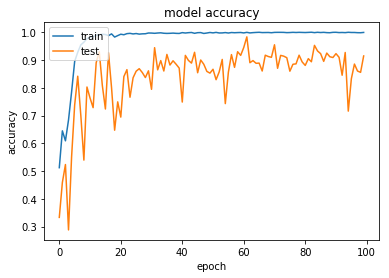

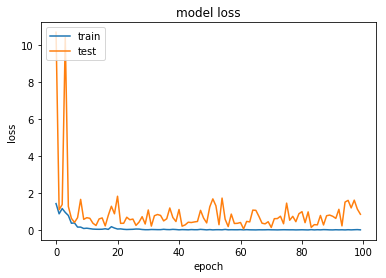

In [16]:
#Summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()